In [54]:
from cmb_simulation import *
from pixell import enmap
from symlens import qe
from scipy.interpolate import interp1d

In [2]:
powers = getCambSpectra()

In [3]:
d = 1/60/180*np.pi
N = 800
cmb = CMBSpectra(powers)
teb = cmb.generatePrimordialMaps(d, N)
p = cmb.generateLensingPotential(d, N)
detector = Detector(*cmb_s4_params)
teb_obs = detector.addNoise(teb)
teb_len = lensTEB(teb, p, lensTaylorNearest)
teb_len_obs = detector.addNoise(teb_len)

In [4]:
shape, wcs = enmap.geometry(shape=(N,N),res=d,pos=(0,0))

In [48]:
T = enmap.enmap(teb_len_obs.T.r, wcs=wcs)
E = enmap.enmap(teb_len_obs.E.r, wcs=wcs)
B = enmap.enmap(teb_len_obs.B.r, wcs=wcs)

In [61]:
modlmap = enmap.modlmap(shape, wcs)
feed_dict = {}
feed_dict['uC_T_T'] = cmb.TT_len(modlmap)
feed_dict['uC_E_E'] = cmb.EE_len(modlmap)
feed_dict['uC_B_B'] = cmb.BB_len(modlmap)
feed_dict['tC_T_T'] = cmb.TT_len(modlmap) + detector.TTn(modlmap)
feed_dict['tC_E_E'] = cmb.EE_len(modlmap) + detector.EEn(modlmap)
feed_dict['tC_B_B'] = cmb.BB_len(modlmap) + detector.BBn(modlmap)
feed_dict['X'] = enmap.fft(E, normalize='phys')
feed_dict['Y'] = enmap.fft(E, normalize='phys')

In [62]:
Nl = qe.N_l(shape, wcs, feed_dict, 'hu_ok', 'EE')
ukappa = qe.unnormalized_quadratic_estimator(shape, wcs, feed_dict, 'hu_ok', 'EE')
norm = qe.A_l(shape, wcs, feed_dict, 'hu_ok', 'EE') # N_l = A_L * L**2 / 4
fkappa = norm * ukappa

/Users/winston/anaconda3/envs/symlens/lib/python3.9/site-packages/symlens-0.3.3-py3.9.egg/symlens/factorize.py:247: UserWarning: No xmask specified; assuming all ones. This is probably not going to end well.
  warnings.warn("No xmask specified; assuming all ones. This is probably not going to end well.")
/Users/winston/anaconda3/envs/symlens/lib/python3.9/site-packages/symlens-0.3.3-py3.9.egg/symlens/factorize.py:250: UserWarning: No xmask specified; assuming all ones. This is probably not going to end well.
  warnings.warn("No xmask specified; assuming all ones. This is probably not going to end well.")
/Users/winston/anaconda3/envs/symlens/lib/python3.9/site-packages/symlens-0.3.3-py3.9.egg/symlens/factorize.py:247: UserWarning: No xmask specified; assuming all ones. This is probably not going to end well.
  warnings.warn("No xmask specified; assuming all ones. This is probably not going to end well.")
/Users/winston/anaconda3/envs/symlens/lib/python3.9/site-packages/symlens-0.3.3-py

In [63]:
est_map = CMBMap(d, N, real=enmap.ifft(fkappa).real/d)

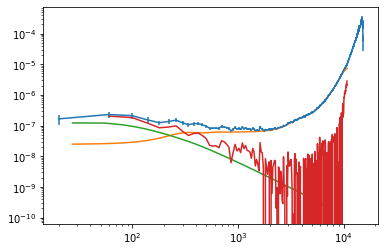

In [64]:
est_avg = est_map.binSpectrum(40)
est_avg.plot()
ls = modlmap[0,N//2+1:]
plt.loglog(ls, Nl[0,N//2+1:])
cmb.pp.plot(ls, scale=scale4)

noise_interp = interp1d(ls, Nl[0,N//2+1:], bounds_error=False)
plt.loglog(est_avg.ls, est_avg.means - noise_interp(est_avg.ls))


(800, 800)